# 2048 Through AI
First we import the Game class and demonstrate the game. Use `wasd` for `up`, `left`, `down` and `right`, respectively. 

In [1]:
from game import Game
from copy import copy
from random import sample
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
import matplotlib.pyplot as plt

In [2]:
game = Game(verbose=True)
game.play_game()

[[ 4  2  8 64]
 [ 0  8  2  4]
 [ 0  0  4  2]
 [ 0  0  2  4]]
exit


# Helper Functions for Function Approximation

In [3]:
def get_state(grid):
    grid[np.where(grid==0)] = 1
    grid.shape = (1,16)
    return poly.fit_transform(np.log2(grid))

def get_move_order(val_r, val_l, val_u, val_d, epsilon = 0.05):
    lst = [val_r, val_l, val_u, val_d]
    idx_max = lst.index(max(lst))
    moves = ['right','left','up','down']
    optimal_move = moves[idx_max]
    moves.pop(idx_max)
    if np.random.rand() <= epsilon:
        return sample(moves, 3) + [optimal_move]
    else:
        return [optimal_move] + sample(moves, 3)

# Function Approximation
We map the state to polynomial features generated from the values of the grid in log space. Specifically, all `0's` (empty cells) are replaced by `1`. Then the $log_2(val)$ is computed for all 16 values, `val`. Next, these 16 numbers are converted into a 153 dimensional space defined by all powers of the form $x^{k_x}y^{k_y}$, where $x$ and $y$ are one of the features and $k_x+k_y\le2$. The value of $153$ is equal to $1+16+120+16$. The $1$ is the bias feature, the first $16$ are the linear features, $120$ comes from all $16$ choose $2$ combinations of grid pairs, and the second $16$ are the single cell quadratic functions. 

Round Number 10
Right Weights:
-0.00015155549351298771 0.0017324230132791886
Left Weights:
0.0 7.75638466488633e-13
Up Weights:
0.0 0.0021387222529668645
Down Weights:
1.2000000000077225e-07 7.500000000048265e-05


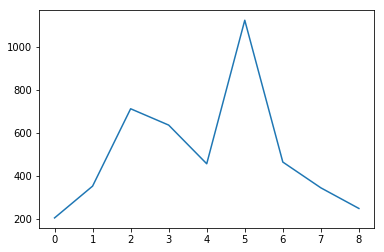

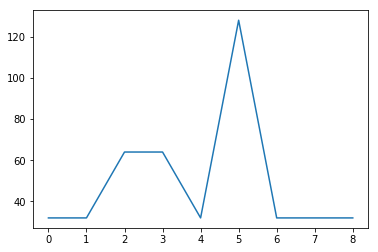




Round Number 20
Right Weights:
-0.0002478365550141021 0.0014472469843478653
Left Weights:
0.0 0.00011523109646828167
Up Weights:
-2.035011882735593e-05 0.002178585022628991
Down Weights:
1.2000000000077225e-07 0.0001450396120205092


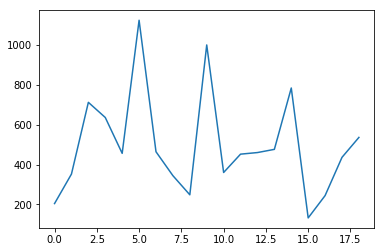

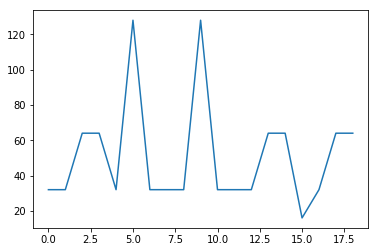




Round Number 30
Right Weights:
-0.0008909194807217903 0.0013559941783691674
Left Weights:
0.0 0.0004771471482433343
Up Weights:
-0.00031838272552256404 0.0020309392098878266
Down Weights:
3.480611596347134e-07 0.00014872920576468985


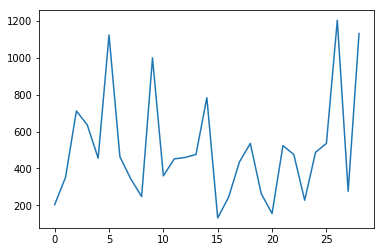

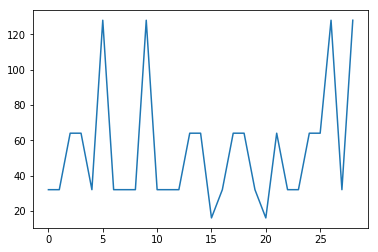




Round Number 50
Right Weights:
-0.0005581483854975779 0.0017999569821347844
Left Weights:
-0.000133993573510525 0.0023252453157806894
Up Weights:
-0.0004920894578111529 0.0024722072233153013
Down Weights:
1.7237987193247355e-06 0.0010741392522181968


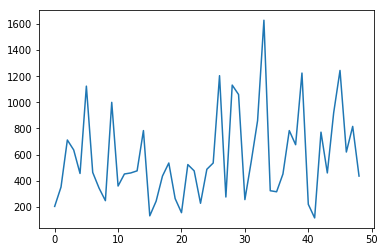

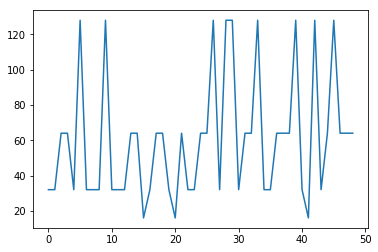




Round Number 100
Right Weights:
-0.0003758873105616272 0.0057933419719111545
Left Weights:
3.088222963207123e-06 0.004537801313553406
Up Weights:
-0.00028465724805043 0.005359006602946577
Down Weights:
-0.00040305599804672413 0.005768100441525824


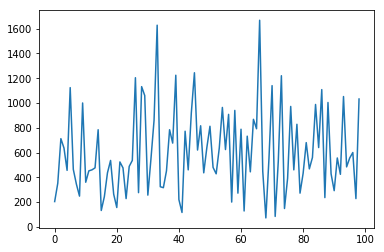

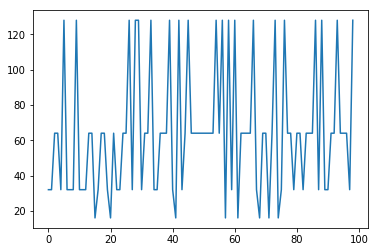




Round Number 300
Right Weights:
-0.006862482813149955 0.02515892754120015
Left Weights:
-0.000861725695129108 0.03758789516126392
Up Weights:
-0.0006814479415729947 0.04875873643191264
Down Weights:
-0.004852171993063262 0.03284545300169986


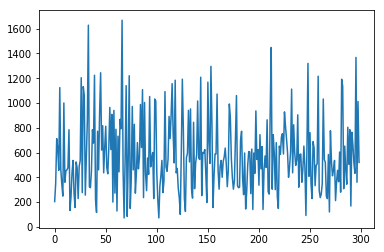

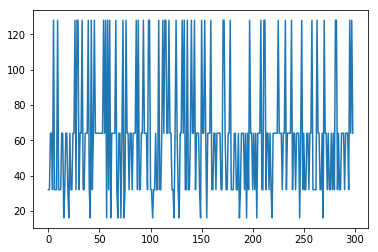

KeyboardInterrupt: 

In [25]:
A = copy(game.grid)
A[np.where(A==0)] = 1
A.shape = (1,16)
poly = PolynomialFeatures(degree = 4, interaction_only=False, include_bias=True) # The defaults, but just to make sure.
tmp = poly.fit_transform(np.log2(A))

n_features = tmp.shape[1]
w_r = np.zeros((1,n_features))
w_l = np.zeros((1,n_features))
w_u = np.zeros((1,n_features))
w_d = np.zeros((1,n_features))

N_episodes = 100000
alpha0 = 1e-8
print_on = [10,20,30,40,50,100,200,300,400,500,
            1000,2000,3000,4000,5000,
            10000,25000,50000,100000]

scores = []
best_cells = []

for n in range(1,N_episodes+1):
    if n > 1:
        scores.append(game.score)
        best_cells.append(game.grid.max())
    
    game = Game()
    alpha = alpha0/max(n-10000,1)
    S = get_state(copy(game.grid)).T
    
    val_r = w_r.dot(S)[0][0]
    val_l = w_l.dot(S)[0][0]
    val_u = w_u.dot(S)[0][0]
    val_d = w_d.dot(S)[0][0]
    
    try_order = get_move_order(val_r, val_l, val_u, val_d)
    
    stage = 0
    while not game.check_over(): # (not game.check_over()) and (stage < 1)
        stage+=1
        
        # Figure out which move we're going to do. 
        # Loop through the above set in order.
        stop = False
        i = 0
        while not stop: # Can't stop, won't stop. 
            move = try_order[i]
            grid0 = copy(game.grid)
            score0 = copy(game.score)
            game.make_move(move)
            is_changed = not(np.prod(grid0 == game.grid))
            if is_changed: # If action changed the grid, stop, and record reward.
                stop = True
                R = game.score - score0
            else:
                i+=1
                stop = (i==4)
            
        if i==4:
            #print('This game is over.') # Will then go to top of first while loop and that will break.
            if n in print_on:
                print('Round Number ' + str(n))
                print('Right Weights:')
                print(min(min(w_r)), max(max(w_r)))
                print('Left Weights:')
                print(min(min(w_l)), max(max(w_l)))
                print('Up Weights:')
                print(min(min(w_u)), max(max(w_u)))
                print('Down Weights:')
                print(min(min(w_d)), max(max(w_d)))
                plt.plot(scores)
                plt.show()
                plt.plot(best_cells)
                plt.show()
                print('\n\n')
        else:
            S_prime = get_state(copy(game.grid)).T
            val_r_prime = w_r.dot(S_prime)[0][0]
            val_l_prime = w_l.dot(S_prime)[0][0]
            val_u_prime = w_u.dot(S_prime)[0][0]
            val_d_prime = w_d.dot(S_prime)[0][0]

            try_order_prime = get_move_order(val_r_prime, val_l_prime, val_u_prime, val_d_prime) 
            
            stop = False
            i = 0
            while not stop: # Can't stop, won't stop. 
                move_prime = try_order[i]
                grid0 = copy(game.grid)
                score0 = copy(game.score)
                game.make_move(move_prime)
                is_changed = not(np.prod(grid0 == game.grid))
                if not is_changed:
                    i+=1
                    stop = (i==4)
            
            if move_prime == 'right':
                next_v = val_r_prime
            elif move_prime == 'left':
                next_v = val_l_prime
            elif move_prime == 'up':
                next_v = val_u_prime
            elif move_prime == 'down':
                next_v = val_d_prime
            
            if move == 'right':
                w_r = w_r + alpha*(R+next_v-val_r)*S.T
            elif move == 'left':
                w_l = w_l + alpha*(R+next_v-val_l)*S.T
            elif move == 'up':
                w_u = w_u + alpha*(R+next_v-val_u)*S.T
            elif move == 'down':
                w_d = w_d + alpha*(R+next_v-val_d)*S.T
                
            S = S_prime
    
            val_r = val_r_prime
            val_l = val_l_prime
            val_u = val_u_prime
            val_d = val_d_prime
    
            try_order = try_order_prime

# Studying Performance of Simple Strategy
Here we implement a strategy that prefers flipping coins between `right` and `up` to using just `right` or just `up` (indifferent). And if neither `right` nor `up` are feasible, it random selects its move. 

In [ ]:
data_list = []
count = 0
target_count = 1000

while count < target_count:
    game = Game()
    score_hist = []
    move_hist = []
    target_hist = []
    off_hist = []
    while len(game.infeasible_moves) < 4:
        score_hist.append(copy(game.score))
        on_target = set(['right','up']).difference(set(game.infeasible_moves))
        off_target = set(['left','down']).difference(set(game.infeasible_moves))
        if on_target:
            act = sample(on_target, 1)[0]
        else:
            act = sample(off_target, 1)[0]
        move_hist.append(act)
        target_hist.append(len(on_target))
        off_hist.append(len(off_target))
        game.make_move(act)
    count+=1
    data_list.append(pd.DataFrame({'Round':[count]*len(score_hist),'Scores':score_hist, 'Moves':move_hist, 
                                   'Targets':target_hist, 'Offs':off_hist}))

In [ ]:
df = pd.concat(data_list)

In [ ]:
df.groupby('Round').Scores.max().describe()